In [149]:
import pandas as pd

import os
import random

import matplotlib.pyplot as plt
import numpy as np

import xgboost

from yellowbrick.classifier import ClassificationReport

from sklearn.metrics import accuracy_score
from sklearn import metrics 

#to save model
import joblib
"""
usage joblib
# save the model: 
joblib.dump(model , "model.pkl")
# load the model:
model = joblib.load("model.pkl")
"""

'\nusage joblib\n# save the model: \njoblib.dump(model , "model.pkl")\n# load the model:\nmodel = joblib.load("model.pkl")\n'

In [ ]:
os.getcwd()

## We want to have a dataframe with:
* X: rows = patients, cols = proteins filled with the protein quantity
* y: rows = patients, col  = health condition (healthy, cancer A, cancer B)

In [ ]:
path = r"rawData\tidy.csv"
tidy = pd.read_csv(path, sep=",")

tidy.head()

tidySub = tidy[["R.FileName", "uniprot", "meanAbu", "Group"]]

tidySub.head()

### To feed the data inot a model we need to reshape

In [ ]:
#reshape data
#X data
tidyReshaped = tidySub.pivot(index = "R.FileName", columns = "uniprot", values = "meanAbu")
tidyReshaped.head()
#y condition
Group =  tidySub.drop(["uniprot", "meanAbu"], axis=1)
Group = Group.drop_duplicates().reset_index(drop=True)
Group.head()

#we merge to ensure that the y rows fit the corresponding x rows
data = pd.merge(tidyReshaped, Group, how="left", on="R.FileName")

#to make df purely numerical
data = data.set_index("R.FileName")

X = data.iloc[:, :-1]
y = data.iloc[:,-1]

### Now that the data is prepared we continue with the following steps:
* Create pipeline for imputing, scaling !! **Scaling is not needed for Random Forest**
* (https://towardsdatascience.com/how-data-normalization-affects-your-random-forest-algorithm-fbc6753b4ddf)
* Creation of training, validation and test sets
* Feature Selection, Engineering
* Model Selection

In [ ]:
#Make pipeline
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

dataPrepPipe = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ]) 

#X is already purely numerical
X = dataPrepPipe.fit_transform(X)

In [125]:
# Encode target labels
from sklearn import preprocessing

labEnc = preprocessing.LabelEncoder() 

# apply label encoding
y = labEnc.fit_transform(y) 
print(y)

[0 3 2 2 1 2 1 0 0 0 1 2 3 0 1 0 3 0 2 0 1 3 0 0 0 3 0 2 0 0 1 0 1 3]


(34, 381)

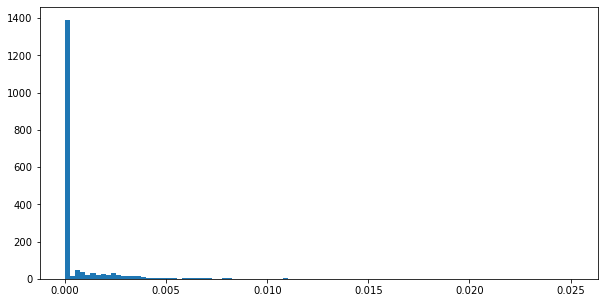

In [117]:
# Feature Selection

"""
Can be used in pipeline
clf = Pipeline([
  ('feature_selection', SelectFromModel(LinearSVC(penalty="l1"))),
  ('classification', RandomForestClassifier())
])
"""
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel #checkout description https://scikit-learn.org/stable/modules/feature_selection.html#tree-based-feature-selection

#create Random Forest classifier with default hyperparameters
raFo = RandomForestClassifier()
raFo = raFo.fit(X, y)

#checkout importance in a histogram
plt.hist(raFo.feature_importances_, bins=100)

#get the reduced X
model = SelectFromModel(estimator = raFo, prefit=True)
X_new = model.transform(X)
X_new.shape   

' plt.rcParams["figure.figsize"] = (10,5)\nplt.bar(raFo.feature_names, raFo.feature_importances_)\nplt.xlabel(\'Feature Labels\')\nplt.ylabel(\'Feature Importances\')\nplt.title(\'Comparison of different Feature Importances\'); '

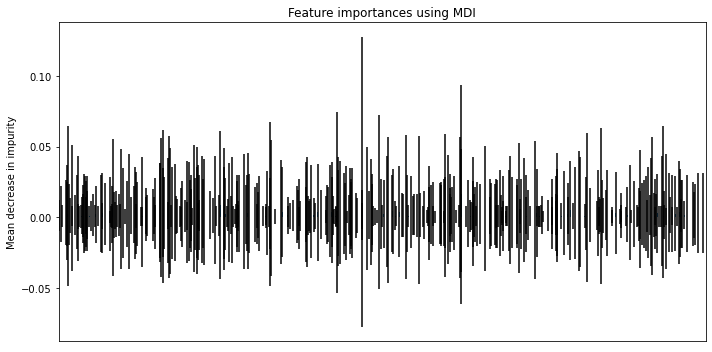

In [118]:
# Visualize feature importance

importances = raFo.feature_importances_
std = np.std([tree.feature_importances_ for tree in raFo.estimators_], axis=0)

forest_importances = pd.Series(importances)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
ax.get_xaxis().set_visible(False)
fig.tight_layout()

""" plt.rcParams["figure.figsize"] = (10,5)
plt.bar(raFo.feature_names, raFo.feature_importances_)
plt.xlabel('Feature Labels')
plt.ylabel('Feature Importances')
plt.title('Comparison of different Feature Importances'); """

In [137]:
#split Data 
X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.2, random_state=0)

## Time to train the model


In [143]:
#split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.2, random_state=0)

clf_RF = RandomForestClassifier(random_state=1)
clf_RF.fit(X_train ,y_train)
y_RFpred = clf_RF.predict(X_test)


clf_XGRF = xgboost.XGBClassifier(tree_method="exact", use_label_encoder =False, random_state=1)
clf_XGRF.fit(X_train ,y_train)
y_XGRFpred = clf_XGRF.predict(X_test)


# Model Accuracy, how often is the classifier correct?
print("Accuracy Random Forest:",metrics.accuracy_score(y_test , y_RFpred))
print("Accuracy XGBoost Random Forest:",metrics.accuracy_score(y_test , y_XGRFpred))

[17:58:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy Random Forest: 0.5714285714285714
Accuracy XGBoost Random Forest: 0.8571428571428571


In [145]:
#save the model
joblib.dump(clf_RF, "Models/clf_RF_X_new.pkl")
joblib.dump(clf_XGRF, "Models/clf_XGRF_X_new.pkl")

['Models/clf_XGRF_X_new.pkl']

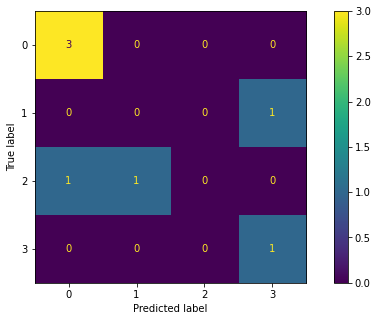

In [142]:
# visualize confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_RFpred, labels=clf_RF.classes_) # calculate value
disp = ConfusionMatrixDisplay(confusion_matrix=cm,              # display
                              display_labels=clf_RF.classes_)
disp.plot(); 

## Compare uncertainty of Data and Model

In [148]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(clf_RF, X_new, y, cv=5, scoring='accuracy')
Udata = scores.std()

lAcc = []
for rs in range(5):
    model = RandomForestClassifier(random_state=random.randrange(100))
    model.fit(X_train, y_train)
    lAcc += [accuracy_score(y_test, model.predict(X_test))]

Umodel = np.std(lAcc)

print("Uncertainty in the data: %.3f" % Udata)
print("Uncertainty in the model: %.3f" % Umodel)
print("The model performance is %.3f ± %.3f ± %.3f" % (scores.mean(),Udata,Umodel))

Uncertainty in the data: 0.056
Uncertainty in the model: 0.000
The model performance is 0.676 ± 0.056 ± 0.000


ClassificationReport(ax=<AxesSubplot:>,
                     classes=['Healthy', 'Cancer A', 'Cancer B'],
                     cmap=<matplotlib.colors.ListedColormap object at 0x00000215A2497EB0>,
                     estimator=RandomForestClassifier(random_state=1))

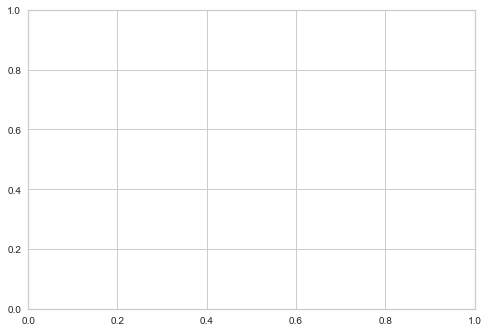